In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Mnist dataset

In [2]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train_mnist = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test_mnist  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

# Galaxies

In [3]:
import os
from astropy.io import fits

image_file=os.path.join('Dataset','Galaxies_SNR_15_50.fits')
hdul=fits.open(image_file)
galaxy_images=np.zeros((0,64,64))
for i in range(len(hdul)-1):
    image=hdul[i+1].data
    galaxy_images=np.append(galaxy_images,[image],axis=0)
hdul.close()

def normalize_image(images):
    #Normalize image to [0,1]
    for i in range(len(images)):
        images[i]=images[i]-images[i].min()
        images[i]=images[i]/images[i].max()
    return images

gal_dataset_images=np.reshape(normalize_image(galaxy_images), (len(galaxy_images), galaxy_images.shape[1], galaxy_images.shape[2], 1))
x_train_gal=gal_dataset_images[:8000]
x_test_gal=gal_dataset_images[8000:8500]

In [4]:
x_train_gal=gal_dataset_images[:8000]
x_test_gal=gal_dataset_images[8000:8500]

# Choose Dataset

In [5]:
x_train=x_train_gal
x_test=x_test_gal
image_size=x_train.shape[1]

# Model

In [6]:
batch_size = 100
latent_dim = 2
dropout_rate = 0.3
start_lr = 0.001

In [7]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [8]:
from keras.layers import Input, Dense 
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda,Conv2D,Conv2DTranspose
from keras.models import Model

from keras.objectives import binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K

In [9]:
def create_vae():
    models = {}

    # Добавим Dropout и BatchNormalization
    def apply_bn_and_dropout(x):
        return Dropout(dropout_rate)(BatchNormalization()(x))

    # Энкодер
    input_img = Input(batch_shape=(batch_size, image_size, image_size, 1))
    x = Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu')(input_img)
    x = Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu')(x)
    x = Flatten()(x)
    # Предсказываем параметры распределений
    # Вместо того, чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    models["encoder"]  = Model(input_img, l, name='Encoder') 
    models["z_meaner"] = Model(input_img, z_mean, name='Enc_z_mean')
    models["z_lvarer"] = Model(input_img, z_log_var, name='Enc_z_log_var')

    # Декодер
    z = Input(shape=(latent_dim, ))
    x = Dense(units=image_size//4*image_size//4*32, activation=tf.nn.relu)(z)
    x = Reshape(target_shape=(image_size//4, image_size//4, 32))(x)
    x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu')(x)
    x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu')(x)
    x = Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same')(x)
    decoded = Reshape((image_size, image_size, 1))(x)

    models["decoder"] = Model(z, decoded, name='Decoder')
    models["vae"]     = Model(input_img, models["decoder"](models["encoder"](input_img)), name="VAE")

    def vae_loss(x, decoded):
        x = K.reshape(x, shape=(batch_size, image_size*image_size))
        decoded = K.reshape(decoded, shape=(batch_size, image_size*image_size))
        xent_loss = image_size*image_size*binary_crossentropy(x, decoded)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return (xent_loss + kl_loss)/2/image_size/image_size

    return models, vae_loss

models, vae_loss = create_vae()
vae = models["vae"]

In [10]:
from keras.optimizers import Adam, RMSprop

vae.compile(optimizer=Adam(start_lr), loss=vae_loss)

In [11]:
def plot_digits(*args, invert_colors=False):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((image_size * len(args), image_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[j * image_size: (j + 1) * image_size,
                   i * image_size: (i + 1) * image_size] = args[j][i].squeeze()

    if invert_colors:
        figure = 1-figure

    plt.figure(figsize=(2*n, 2*len(args)))
    plt.imshow(figure, cmap='Greys_r')
    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()


n = 15 # Картинка с 15x15 цифр

from scipy.stats import norm
# Так как сэмплируем из N(0, I), то сетку узлов, в которых генерируем цифры берем из обратной функции распределения
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

def draw_manifold(generator, show=True):
    # Рисование цифр из многообразия
    figure = np.zeros((image_size * n, image_size * n))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.zeros((1, latent_dim))
            z_sample[:, :2] = np.array([[xi, yi]])

            x_decoded = generator.predict(z_sample)
            digit = x_decoded[0].squeeze()
            figure[i * image_size: (i + 1) * image_size,
                   j * image_size: (j + 1) * image_size] = digit
    if show:
        # Визуализация
        plt.figure(figsize=(15, 15))
        plt.imshow(figure, cmap='Greys_r')
        plt.grid(None)
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)        
        plt.show()
    return figure

In [12]:
from IPython.display import clear_output
from keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard

# Массивы в которые будем сохранять результаты, для последующей визуализации
figs = []
latent_distrs = []
epochs = []

# Эпохи в которые будем сохранять
save_epochs = set(list((np.arange(0, 59)**1.701).astype(np.int)) + list(range(10)))

# Отслеживать будем на вот этих цифрах
imgs = x_test[:batch_size]
n_compare = 10

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]


# Фунция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
    if epoch in save_epochs:
        clear_output() # Не захламляем output

        # Сравнение реальных и декодированных цифр
        decoded = vae.predict(imgs, batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])

        # Рисование многообразия
        figure = draw_manifold(generator, show=True)

        # Сохранение многообразия и распределения z для создания анимации после
        epochs.append(epoch)
        figs.append(figure)
        latent_distrs.append(encoder_mean.predict(x_test, batch_size))

        
# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)
lr_red = ReduceLROnPlateau(factor=0.1, patience=25)
tb     = TensorBoard(log_dir='./logs')

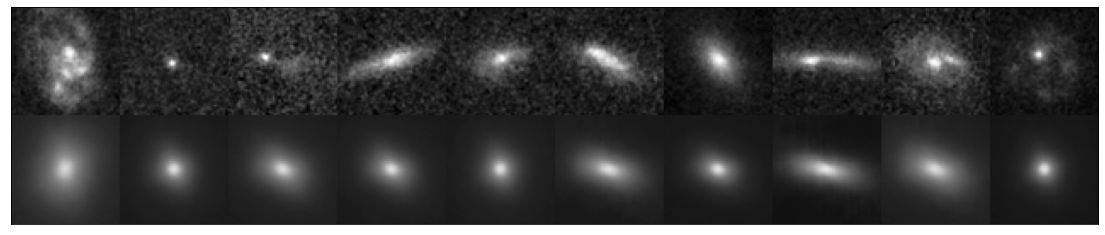

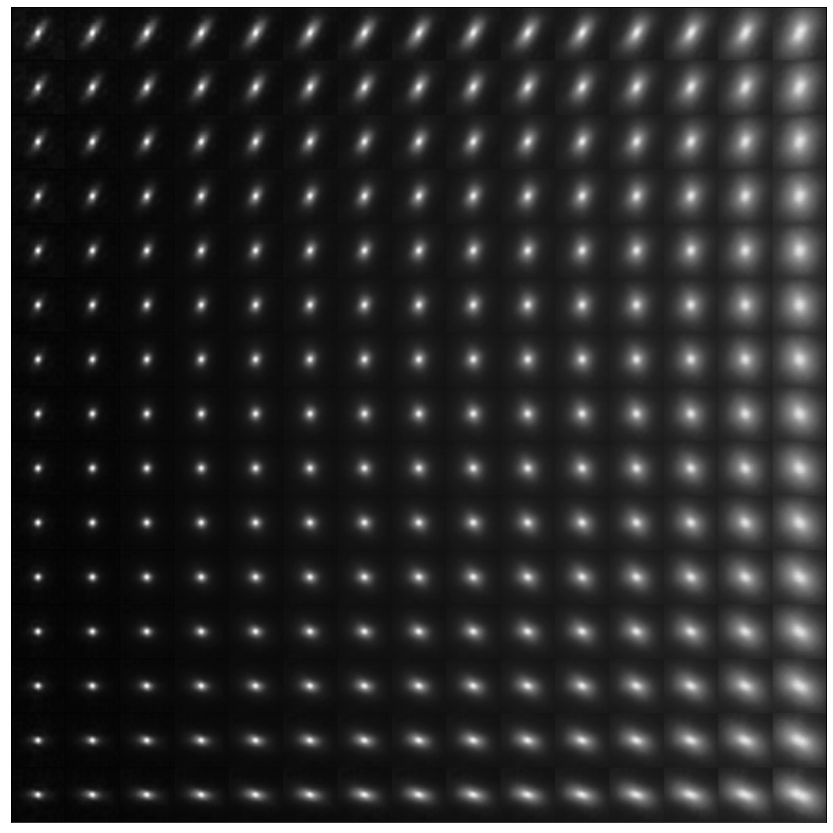

8000/8000 [==============================] - 98s 12ms/sample - loss: 0.1977 - val_loss: 0.1990
Epoch 36/1000
8000/8000 [==============================] - 96s 12ms/sample - loss: 0.1976 - val_loss: 0.1990
Epoch 37/1000
8000/8000 [==============================] - 97s 12ms/sample - loss: 0.1976 - val_loss: 0.1990
Epoch 38/1000
8000/8000 [==============================] - 94s 12ms/sample - loss: 0.1976 - val_loss: 0.1989
Epoch 39/1000
8000/8000 [==============================] - 96s 12ms/sample - loss: 0.1976 - val_loss: 0.1990
Epoch 40/1000
8000/8000 [==============================] - 99s 12ms/sample - loss: 0.1976 - val_loss: 0.1989
Epoch 41/1000
8000/8000 [==============================] - 98s 12ms/sample - loss: 0.1976 - val_loss: 0.1990
Epoch 42/1000
1800/8000 [=====>........................] - ETA: 1:11 - loss: 0.1975

KeyboardInterrupt: 

In [13]:
# Запуск обучения 
#conv_vae.compile(optimizer=Adam(start_lr*5), loss=vae_loss)
vae.fit(x_train, x_train, shuffle=True, epochs=1000,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[pltfig, lr_red, tb],
        verbose=1)

# Save model

In [23]:
vae.save_weights('Conv_Vae')

# Load model

In [19]:
from keras.models import load_model
models, vae_loss = create_vae()
conv_vae = models["vae"]
conv_vae.compile(optimizer=Adam(start_lr), loss=vae_loss)
conv_vae.load_weights('Conv_Vae')
#conv_vae=load_model('galaxies_Conv_VAE',custom_objects={'vae_loss': vae_loss})

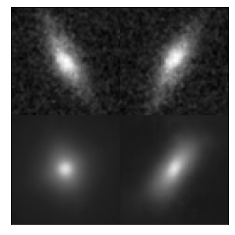

In [20]:
pictures=np.zeros_like(x_test)
pictures[0]=x_test[350,:,:]
pictures[1]=x_test[350,::-1,:]
decoded = conv_vae.predict(pictures, batch_size=batch_size)
plot_digits(pictures[:2], decoded[:2])

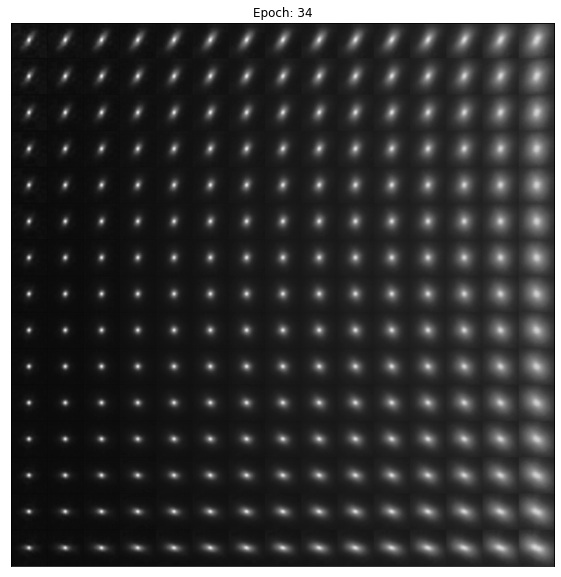

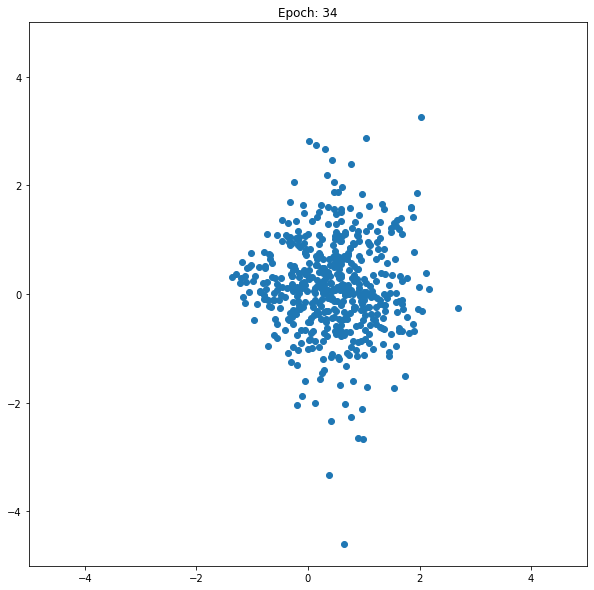

In [22]:
from matplotlib.animation import FuncAnimation
from matplotlib import cm
import matplotlib

def make_2d_figs_gif(figs, epochs, fname, fig): 
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1, clip=False)
    im = plt.imshow(np.zeros((image_size,image_size)), cmap='Greys_r', norm=norm)
    plt.grid(None)
    plt.title("Epoch: " + str(epochs[0]))

    def update(i):
        im.set_array(figs[i])
        im.axes.set_title("Epoch: " + str(epochs[i]))
        im.axes.get_xaxis().set_visible(False)
        im.axes.get_yaxis().set_visible(False)
        return im
    
    anim = FuncAnimation(fig, update, frames=range(len(figs)), interval=100)
    anim.save(fname, dpi=80, writer='imagemagick')

def make_2d_scatter_gif(zs, epochs, fname, fig):
    im = plt.scatter(zs[0][:, 0], zs[0][:, 1], cmap=cm.coolwarm)
    plt.colorbar()
    plt.title("Epoch: " + str(epochs[0]))

    def update(i):
        fig.clear()
        im = plt.scatter(zs[i][:, 0], zs[i][:, 1], cmap=cm.coolwarm)
        im.axes.set_title("Epoch: " + str(epochs[i]))
        im.axes.set_xlim(-5, 5)
        im.axes.set_ylim(-5, 5)
        return im

    anim = FuncAnimation(fig, update, frames=range(len(zs)), interval=150)
    anim.save(fname, dpi=80, writer='imagemagick')
    
make_2d_figs_gif(figs, epochs, "./figs3/manifold.gif", plt.figure(figsize=(10,10)))
make_2d_scatter_gif(latent_distrs, epochs, "./figs3/z_distr.gif", plt.figure(figsize=(10,10)))